<a href="https://colab.research.google.com/github/jtrussell10/BaseballClutch/blob/master/ClutchPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [675]:
%%capture
import sys

!pip install category_encoders==2.*
!pip install pandas-profiling==2.*

In [676]:
#Importing everything necessary 
import pandas as pd
import numpy as np

import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lars
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


In [677]:
#Importing 2002 to 2017 samples, leaving out 2018 and 2019 to avoid leakage
df2 = pd.read_csv('/content/FanGraphs Leaderboard-95.csv')

In [678]:
#Mapping player handedness
map = pd.read_csv('/content/Handedness.csv')

In [679]:
#Merging dataframes
map['playerid'] = map['playerid'].astype(object)
df2['playerid'] = df2['playerid'].astype(object)
df = pd.merge(df2,map,how='left')

In [681]:
#Wrangling
def wrangle(df):
  df = df.drop(['RBI','Name','Team','playerid'], axis=1)
  df['WAR/PA'] = df['WAR'] / df['PA']
  df['GDP/PA'] = df['GDP'] / df['PA']
  df['SB/PA'] = df['SB'] / df['PA']
  df['CS/PA'] = df['CS'] / df['PA']
  df['IBB/PA'] = df['IBB'] / df['PA']
  df['CLUTCH/PA'] = df['Clutch'] / df['PA']
  df['Off/PA'] = df['Off'] / df['PA']
  df['Def/PA'] = df['Def'] / df['PA']
  df['BB%'] = (df['BB%'].str.strip('%').astype(float))
  df['K%'] = (df['K%'].str.strip('%').astype(float))
  df['LD%'] = (df['LD%'].str.strip('%').astype(float))
  df['GB%'] = (df['GB%'].str.strip('%').astype(float))
  df['FB%'] = (df['FB%'].str.strip('%').astype(float))
  df['IFFB%'] = (df['IFFB%'].str.strip('%').astype(float))
  df['O-Swing% (pfx)'] = (df['O-Swing% (pfx)'].str.strip('%').astype(float))
  df['Z-Swing% (pfx)'] = (df['Z-Swing% (pfx)'].str.strip('%').astype(float))
  df['Swing% (pfx)'] = (df['Swing% (pfx)'].str.strip('%').astype(float))
  df['O-Contact% (pfx)'] = (df['O-Contact% (pfx)'].str.strip('%').astype(float))
  df['Z-Contact% (pfx)'] = (df['Z-Contact% (pfx)'].str.strip('%').astype(float))
  df['Contact% (pfx)'] = (df['Contact% (pfx)'].str.strip('%').astype(float))
  df['Zone% (pfx)'] = (df['Zone% (pfx)'].str.strip('%').astype(float))
  df['Pull%'] = (df['Pull%'].str.strip('%').astype(float))
  df['Cent%'] = (df['Cent%'].str.strip('%').astype(float))
  df['Oppo%'] = (df['Oppo%'].str.strip('%').astype(float))
  df['Soft%'] = (df['Soft%'].str.strip('%').astype(float))
  df['Med%'] = (df['Med%'].str.strip('%').astype(float))
  df['Hard%'] = (df['Hard%'].str.strip('%').astype(float))
  df['K%+'] = df['K%+'].astype(float)

  return df

df = wrangle(df)

In [682]:
#X and y split
X = df.drop('Clutch', axis=1)
X = X.drop('CLUTCH/PA', axis=1)
y = df['CLUTCH/PA']

In [683]:
#Training and validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=45)

In [699]:
#PCA model 20 components
model = make_pipeline(ce.OneHotEncoder(), SimpleImputer(strategy='mean'), 
                      PCA(n_components=20), LinearRegression())


model.fit(X_train, y_train)
print ('R2 Score with 20 components:', model.score(X_val, y_val))

R2 Score with 20 components: 0.05931988829826751


In [698]:
#PCA model 60 components
model = make_pipeline(ce.OneHotEncoder(), SimpleImputer(strategy='mean'), 
                      PCA(n_components=60), LinearRegression())


model.fit(X_train, y_train)
print ('R2 Score with 60 compon', model.score(X_val, y_val))

R2 Score with 60 components: 0.04831715170988249


In [643]:
#Attempting classification, classifying as negative or positive
dfC = df['CLUTCH/PA']
conditions = [
    (df['Clutch'] > 0.00000001),
    (df['Clutch'] < 0.00000001)]
choices = [1,0]
df['CLUTCH/PA'] = np.select(conditions, choices)

In [644]:
# Baseline for RandomForest, 44.8% of players have positive "clutch, which means baseline is 55.2% accuracy"
df['CLUTCH/PA'].mean()

0.44828778969214805

In [645]:
X = df.drop('Clutch', axis=1)
X = X.drop('CLUTCH/PA', axis=1)
y = df['CLUTCH/PA']

In [646]:

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=45)

In [647]:
#Baseline is 55.2% accuracy, RFC scores 58.2% accuracy
model = make_pipeline(ce.OneHotEncoder(), SimpleImputer(strategy='mean'),
    RandomForestClassifier(max_depth=5, random_state=42))


model.fit(X_train, y_train)
print ('Validation Accuracy', model.score(X_val, y_val))

Validation Accuracy 0.5820379965457686


In [703]:
#Switching categorical back to continuous 
df['CLUTCH/PA'] = dfC

In [649]:
#Selecting three primary features
df =df[['K%+','ISO+','Handedness','Clutch','CLUTCH/PA']]

In [650]:
X = df.drop('Clutch', axis=1)
X = X.drop('CLUTCH/PA', axis=1)
y = df['CLUTCH/PA']

In [651]:

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=45)

In [652]:
#Linear regression model
model = make_pipeline(ce.OneHotEncoder(),
    LinearRegression())


model.fit(X_train, y_train)
print ('Validation Accuracy', model.score(X_val, y_val))

Validation Accuracy 0.05919577181912372


In [653]:

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=45)

In [654]:
#Ridge model to reduce overfitting

model = make_pipeline(ce.OneHotEncoder(),
    Ridge(alpha=200, solver='auto'))


model.fit(X_train, y_train)
print ('Validation Accuracy', model.score(X_val, y_val))

Validation Accuracy 0.05761884344686585


In [655]:
#Test data
df3 = pd.read_csv('/content/FanGraphs Leaderboard-98.csv')

In [656]:
#Merging with handedness
map['playerid'] = map['playerid'].astype(object)
df3['playerid'] = df3['playerid'].astype(object)
df = pd.merge(df3,map,how='left')

In [658]:
df = wrangle(df)

In [659]:
df =df[['K%+','ISO+','Handedness','Clutch','CLUTCH/PA']]

In [660]:
X2 = df.drop('Clutch', axis=1)
X2 = X2.drop('CLUTCH/PA', axis=1)
y2 = df['CLUTCH/PA']

In [661]:
#Applying model to test data
y_pred = model.predict(X2)

In [702]:
#Applying predictive model to players in 2018 and 2019. Test data.
from sklearn.metrics import r2_score

print ('R2 Score:', r2_score(y2, y_pred2))

R2 Score: 0.045174594992186456


In [ ]:
#Below is model coefficient things

In [700]:
df4 = X2
df4 ['CLUTCH/PA'] = y2
df4 ['clutchPred'] = y_pred2
df4 ['CLUTCH/PA*600'] = df4 ['CLUTCH/PA'] * 600
df4 ['clutchPred*600'] = df4 ['clutchPred'] * 600

In [664]:
df4['Per600'] = df4['clutchPred'] * 600

In [665]:
df4['Name'] = df3['Name']
df4['Season'] = df3['Season']
df4['PA'] = df3['PA']
df4['WAR'] = df3['WAR']
df4['ClutchADJ'] = df4['WAR'] + (df4['clutchPred'] * df4['PA'])

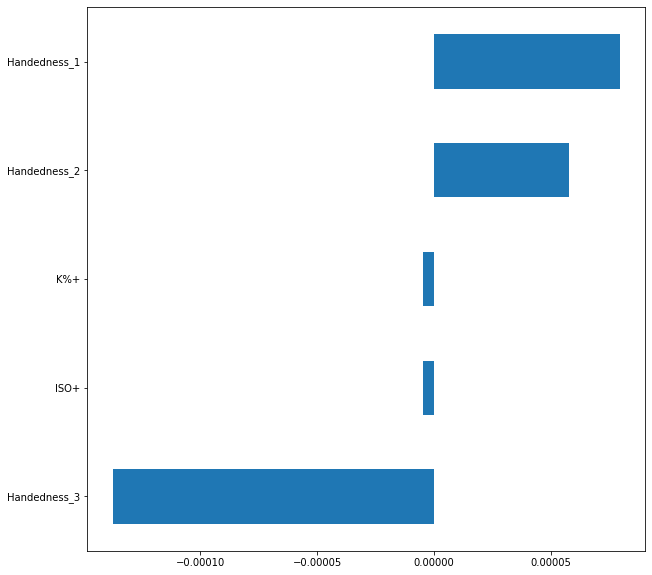

In [666]:
classifier = model.named_steps['ridge']
feature_names = model.named_steps['onehotencoder'].feature_names

# Gets model coefs
coef_ = classifier.coef_
importances = pd.Series(coef_, index=feature_names)
import matplotlib.pyplot as plt

# Plots coefs 
plt.figure(figsize=(10,10), facecolor='white')
importances.sort_values().plot(kind='barh')

In [667]:
import matplotlib.pyplot as plt
df3['CLUTCH/PA'] = 600 * (df3['Clutch'] / df3['PA'])
df7 = df3.pivot(index='Name', columns='Season', values='CLUTCH/PA').dropna()


In [668]:
import matplotlib.pyplot
import pylab

In [669]:
df10 = pd.read_csv('/content/clutchyearrs.csv')

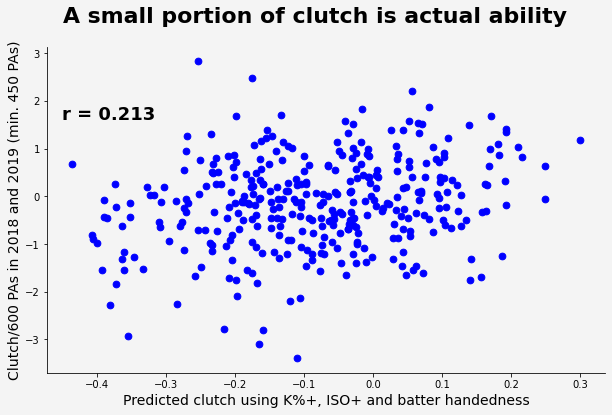

In [672]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)


# Spines

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Axis Labels

ax.set_ylabel('Clutch/600 PAs in 2018 and 2019 (min. 450 PAs)', fontsize=14, fontweight='normal', y=0.5)
ax.set_xlabel('Predicted clutch using K%+, ISO+ and batter handedness', fontsize=14, fontweight='normal', y=0.5)

#line

ax.scatter(df4 ['clutchPred*600'], df4 ['CLUTCH/PA*600'],c='blue',s=45)

#title 

ax.set_title("A small portion of clutch is actual ability", fontsize = 22,
             x= .48, y = 1.055, fontweight='bold')

#r2

ax.text(s='r = 0.213', x=-0.45, y=1.6, fontsize = 18, weight='normal',
        fontweight = 'bold', color='black')


fig.set_facecolor('#f4f4f4')
ax.set_facecolor('#f4f4f4')

plt.savefig('PredictedClutch',  bbox_inches='tight')

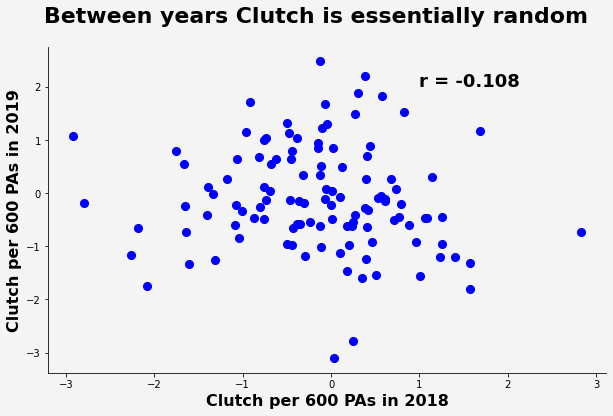

In [673]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)


# Spines

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Axis Labels

ax.set_ylabel('Clutch per 600 PAs in 2019', fontsize=16, fontweight='bold', y=0.5)
ax.set_xlabel('Clutch per 600 PAs in 2018', fontsize=16, fontweight='bold', y=0.5)

#line

ax.scatter(df10['2018'], df10["2019"],c='blue',s=65)

#title 

ax.set_title("Between years Clutch is essentially random", fontsize = 22,
             x= .48, y = 1.055, fontweight='bold')

#r2

ax.text(s='r = -0.108', x=1, y=2, fontsize = 18, weight='normal',
        fontweight = 'bold', color='black')


fig.set_facecolor('#f4f4f4')
ax.set_facecolor('#f4f4f4')

plt.savefig('ClutchYears',  bbox_inches='tight')